In [553]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns


In [554]:
data = pd.read_csv("deep_diabetes.csv")
data.drop(columns=["BloodPressure", "SkinThickness"])

,Pregnancies,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,125,33.6,0.627,50,1
1,1,85,125,26.6,0.351,31,0
2,8,183,125,23.3,0.672,32,1
3,1,89,94,28.1,0.167,21,0
4,0,137,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...
763,10,101,180,32.9,0.171,63,0
764,2,122,125,36.8,0.340,27,0
765,5,121,112,26.2,0.245,30,0
766,1,126,125,30.1,0.349,47,1


In [555]:
X = data.drop("Outcome", axis=1).values
y = data["Outcome"].values


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=43, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=43)
X_train_balanced, y_train_balanced = smote.fit_resample(
    X_train_scaled, y_train)

X_train_tensor = torch.FloatTensor(X_train_balanced)
y_train_tensor = torch.FloatTensor(y_train_balanced)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test)

In [556]:
class DiabetesNN(nn.Module):
    def __init__(self, input_size, dropout_rate=0.5):
        super(DiabetesNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(32, 16)
        self.bn3 = nn.BatchNorm1d(16)
        self.dropout3 = nn.Dropout(dropout_rate)

        self.fc4 = nn.Linear(16, 1)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)

        x = nn.functional.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)

        x = nn.functional.relu(self.fc3(x))
        x = self.bn3(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        return x


In [557]:
torch.manual_seed(42)
model = DiabetesNN(input_size=X_train.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=10, factor=0.5, min_lr=1e-6)

In [558]:
def evaluate_model(model, X, y):
    model.eval()
    with torch.no_grad():
        outputs = model(X).squeeze()
        predictions = (outputs >= 0.5).float()
        accuracy = (predictions == y).float().mean()
        precision = precision_score(y.numpy(), predictions.numpy())
        recall = recall_score(y.numpy(), predictions.numpy())
        f1 = f1_score(y.numpy(), predictions.numpy())
    return accuracy, precision, recall, f1

In [559]:
num_epochs = 500
best_loss = float('inf')
patience = 20
patience_counter = 0

criterion = nn.BCEWithLogitsLoss()


for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train_tensor).squeeze()
    loss = criterion(outputs, y_train_tensor)

    loss.backward()
    optimizer.step()

    if loss.item() < best_loss:
        best_loss = loss.item()
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    scheduler.step(loss)


model.eval()
train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(model, X_train_tensor, y_train_tensor)
print(f"Epoch [{epoch+1}/{num_epochs}]")
print(f"Loss: {loss.item():.2f}")
print(f"Train Metrics - Accuracy: {train_accuracy:.2f}, Precision: {train_precision:.2f}, ")
print(f"Recall: {train_recall:.2f}, F1 Score: {train_f1:.2f}\n")

Early stopping at epoch 141
Epoch [141/500]
Loss: 0.48
Train Metrics - Accuracy: 0.80, Precision: 0.82, 
Recall: 0.77, F1 Score: 0.79



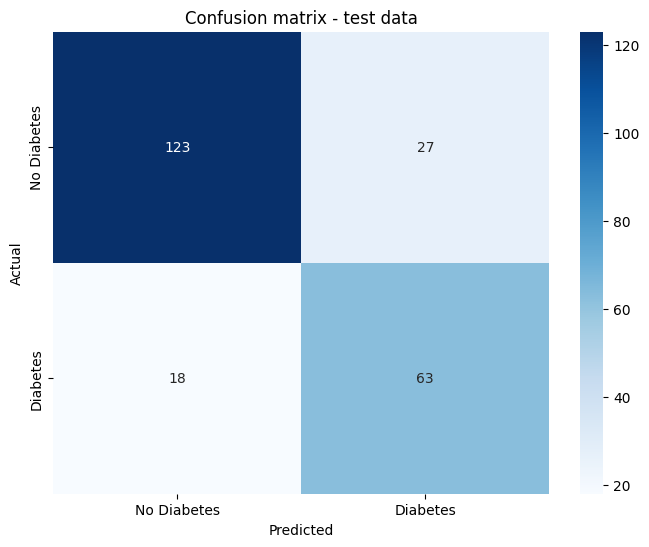

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.82      0.85       150
           1       0.70      0.78      0.74        81

    accuracy                           0.81       231
   macro avg       0.79      0.80      0.79       231
weighted avg       0.81      0.81      0.81       231

Accuracy on test data: 0.81


In [560]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor).numpy().flatten()
    y_test_pred = (y_test_pred >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Diabetes", "Diabetes"], yticklabels=["No Diabetes", "Diabetes"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion matrix - test data")
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_test_pred))

accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy on test data: {accuracy:.2f}")
